In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-08 11:30:22.885060: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
L_vars = 10

In [6]:
filename_neg_storm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_256/*neg*.npy"))
filename_pos_storm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_256/*pos*.npy"))

In [7]:
ind_pick_from_batch = [1, 2, 5, 9, 10, 11, 12, 13, 17, 18]
L_vars = len(ind_pick_from_batch)

In [30]:
with h5py.File(save_dir_scratch+'VALID_256_lead{}.hdf'.format(21), 'r') as h5io:
    TEST_input = h5io['TEST_input'][5000:7000, 48:-48, 48:-48, ...]
    TEST_target = h5io['TEST_target'][5000:7000, ...]

TEST_target[np.isnan(TEST_target)] = 0.0
TEST_target[TEST_target!=0] = 1.0

TEST_input = TEST_input[..., ind_pick_from_batch]

In [31]:
TEST_input.shape

(2000, 160, 160, 10)

**ConvNext**

In [32]:
MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
    },
}

In [33]:
model = ck.ConvNeXt(
        depths=MODEL_CONFIGS["small"]["depths"],
        projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
        drop_path_rate=0.0,
        layer_scale_init_value=1e-6,
        model_name='test',
        input_shape=(160, 160, 10),
        pooling='max',
        classes=1,
    )#0.5 #0.1 #1e-6

In [34]:
def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {}'.format(CSI, AUC, freq))
    metric = CSI_metric


    return metric

In [44]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [53]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'CONVNEXT_160'

model_name = '{}_pp10_tune'.format(key)
model_path = temp_dir+model_name

W_old = k_utils.dummy_loader(temp_dir+'CONVNEXT_160_pp10')
        
model.set_weights(W_old)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-6))

In [54]:
L_vars

10

In [55]:
X_batch = np.empty((batch_size, 160, 160, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [56]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [57]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred, thres=0.5)
print("Initial record: {}".format(record))

0.08333333333333333 0.8737121212121212 4.85
Initial record: 0.9166666666666666


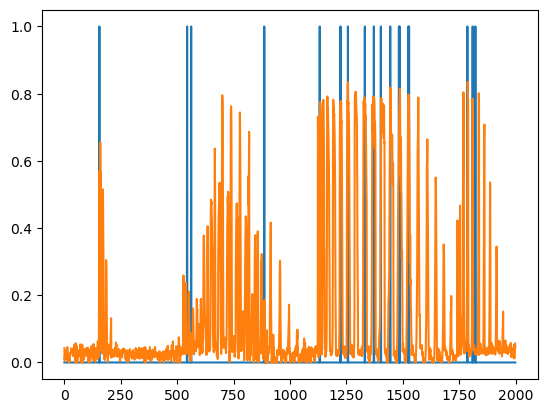

In [61]:
plt.plot(TEST_target)
plt.plot(Y_pred)

In [59]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [60]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(15, 30))
N_storm = batch_size - N_aug


L_storm = len(filename_neg_storm)
L_aug = len(filename_pos_storm)

for i in range(epochs):
    
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_storm[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != batch_size:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            for c, v in enumerate(ind_pick_from_batch):
                X_batch[k, ..., c] = data[:, 48:-48, 48:-48, v]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.7, 0.90)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.00, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06278026905829596 0.8774242424242423 10.85
Validation loss 0.9372197309417041 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05909090909090909 0.8744949494949495 10.65
Validation loss 0.9409090909090909 NOT improved


KeyboardInterrupt: 

In [84]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'CONVNEXT_ALL'

model_name = '{}_pp20_tune2'.format(key)
model_path = temp_dir+model_name

# W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'CONVNEXT_ALL_pp20_tune')

# for l in range(len(W_old)):
#     if W_old[l].shape == W_new[l].shape:
#         W_new[l] = W_old[l]
        
model.set_weights(W_old)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-6))

0.0684931506849315 0.022009152320767052 0.8330370117670854 4.538461538461538


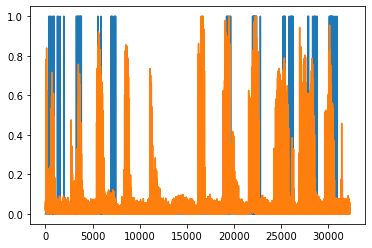

In [88]:
#Y_pred = model.predict([TEST_input,])

Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1

record = verif_metric(TEST_target, Y_pred, thres=0.5)

plt.plot(TEST_target)
plt.plot(Y_pred)

In [89]:
model.save(model_path)

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/CONVNEXT_ALL_pp20_tune2/assets


In [86]:
N_aug = int(np.random.uniform(20, 35))
# N_wind = int(np.random.uniform(10, 15))
# N_hail = int(np.random.uniform(7, 13))
N_storm = int(np.random.uniform(25, 35))
N_calm = 100 - N_aug - N_storm

L_storm = len(filename_neg_storm)
L_calm = len(filename_neg_calm)
# L_wind = len(filename_neg_wind)
# L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_calm = du.shuffle_ind(L_calm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_calm = []
        for ind_temp in ind_calm[:N_calm]:
            file_pick_calm.append(filename_neg_calm[ind_temp])
            
#         file_pick_wind = []
#         for ind_temp in ind_wind[:N_wind]:
#             file_pick_wind.append(filename_neg_wind[ind_temp])
            
#         file_pick_hail = []
#         for ind_temp in ind_hail[:N_hail]:
#             file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_calm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.06620553359683795 0.026242878934097064 0.850839239041797 5.384615384615385
Validation loss 1.6239586500456067 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06726907630522089 0.025744793450175888 0.8489814575521198 5.289940828402367
Validation loss 1.6041729046362967 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06774519716885744 0.025526881050960373 0.8474097436499166 5.2485207100591715
Validation loss 1.5955079842767486 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0681586978636826 0.02534009899448993 0.8470137067451715 5.21301775147929
Validation loss 1.5880765920049122 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06797116374871266 0.024966534881549044 0.8460867961848567 5.136094674556213
Validation loss 1.5728420039122724 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06846473029045644 0.024748622482333532 0.845467320784551 5.094674556213017
Validation loss 1.5641631270102385 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06918238993710692 0.024437319054882795 0.8444845966511488 5.035502958579881
Validation loss 1.551754679766291 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06969376979936642 0.02421940665566728 0.8438063604263716 4.994082840236686
Validation loss 1.5430615522078441 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07036247334754797 0.023939233570961616 0.842753178564567 4.940828402366864
Validation loss 1.5318757017953346 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06951871657754011 0.023845842542726394 0.8421396897686353 4.9171597633136095
Validation loss 1.52781697940069 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06852248394004283 0.02381471219998132 0.841162583833184 4.905325443786983
Validation loss 1.5262471016053625 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06896551724137931 0.02362793014351088 0.840067587842367 4.8698224852071
Validation loss 1.5187920832483166 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06986899563318777 0.023254366030569996 0.8388564517266933 4.798816568047338
Validation loss 1.5038681171029173 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07032967032967033 0.023067583974099554 0.8383291700337479 4.763313609467455
Validation loss 1.4963989856297548 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07079646017699115 0.022880801917629114 0.83817443933608 4.727810650887574
Validation loss 1.488924962035922 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07015590200445435 0.02269401986115867 0.8381956227054036 4.686390532544379
Validation loss 1.4811533849053125 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07046979865771812 0.022569498490178377 0.8370744698585522 4.662721893491124
Validation loss 1.4761685397720505 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0707070707070707 0.022476107461943156 0.8362984217284635 4.644970414201183
Validation loss 1.4724284262745801 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07102593010146561 0.022351586090962862 0.8359940259214443 4.621301775147929
Validation loss 1.4674396109484134 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.07013574660633484 0.02225819506272764 0.8348815306255339 4.597633136094674
Validation loss 1.463418029933867 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06818181818181818 0.022133673691747346 0.8337254712701013 4.562130177514793
Validation loss 1.4578805809575042 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.06825938566552901 0.022102543349002274 0.8335897135032191 4.556213017751479
Validation loss 1.4566350950178726 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0684931506849315 0.022009152320767052 0.8330370117670854 4.538461538461538
Validation loss 1.4528977871443627 NOT improved


KeyboardInterrupt: 

In [36]:
model.save(model_path)

TypeError: len is not well defined for symbolic Tensors. (Shape_1:0) Please call `x.shape` rather than `len(x)` for shape information.

In [ ]:
verif_metric(TEST_target, Y_pred, thres=0.5)

In [38]:
Y_pred = model.predict([TEST_input,])
record = verif_metric(TEST_target, Y_pred, thres=0.5)

0.11864406779661017 0.011340623734305387 0.9011255699708647 1.1290322580645162


In [39]:
record = verif_metric(TEST_target, Y_pred, thres=0.5)

0.11864406779661017 0.011340623734305387 0.9011255699708647 1.1290322580645162


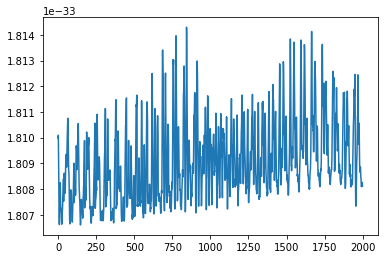

In [28]:
plt.plot(Y_pred.ravel())

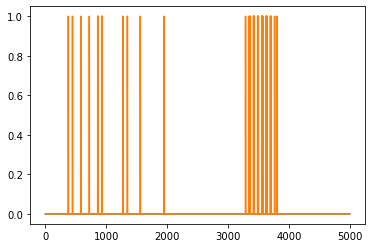

In [31]:
plt.plot(Y_pred.ravel())
plt.plot(TEST_target.ravel())

In [ ]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(10, 22))
# N_wind = int(np.random.uniform(10, 15))
# N_hail = int(np.random.uniform(7, 13))
N_storm = int(np.random.uniform(14, 32))
N_calm = 100 - N_aug - N_storm

L_storm = len(filename_neg_storm)
L_calm = len(filename_neg_calm)
# L_wind = len(filename_neg_wind)
# L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_calm = du.shuffle_ind(L_calm)
        # ind_wind = du.shuffle_ind(L_wind)
        # ind_hail = du.shuffle_ind(L_hail)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_calm = []
        for ind_temp in ind_calm[:N_calm]:
            file_pick_calm.append(filename_neg_calm[ind_temp])
            
#         file_pick_wind = []
#         for ind_temp in ind_wind[:N_wind]:
#             file_pick_wind.append(filename_neg_wind[ind_temp])
            
#         file_pick_hail = []
#         for ind_temp in ind_hail[:N_hail]:
#             file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_calm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.08974358974358974 0.019036046982584043 0.8747827904728307 1.7419354838709677
Validation loss 0.8765922249793219 NOT improved
0.07317073170731707 0.020656136087484813 0.8842420204078967 1.8387096774193548
Validation loss 0.9092053501180174 NOT improved
0.08148148148148149 0.014783313082219522 0.8798978298645135 1.3548387096774193
Validation loss 0.8057825567502986 NOT improved
0.0963855421686747 0.021061158363710003 0.8881713897490168 1.935483870967742
Validation loss 0.9099883404586088 NOT improved
0.07291666666666667 0.00688537869582827 0.8882857105527899 0.6612903225806451
Validation loss 0.8094086021505377 NOT improved
0.11 0.007695423248278655 0.8938743647029618 0.7903225806451613
Validation loss 0.7539354838709679 NOT improved
0.08403361344537816 0.011543134872417983 0.890186702204105 1.0806451612903225
Validation loss 0.748902141501762 NOT improved
0.06451612903225806 0.006277845281490482 0.8922150798939102 0.5967741935483871
Validation loss 0.8290322580645163 NOT improved
0.12

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [57]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     55296
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53     55296
   macro avg       0.50      0.27      0.35     55296
weighted avg       1.00      0.53      0.69     55296



/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [58]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.9319409017491813

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

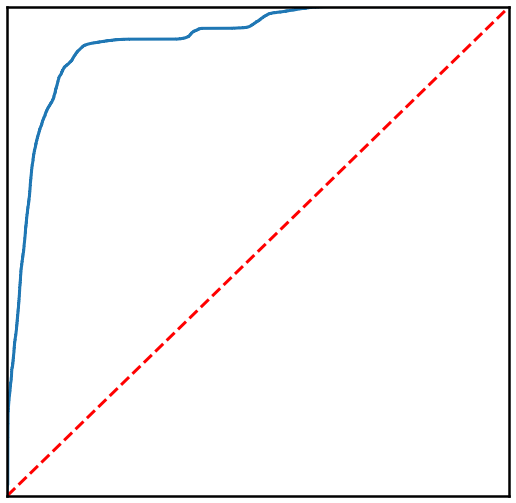

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

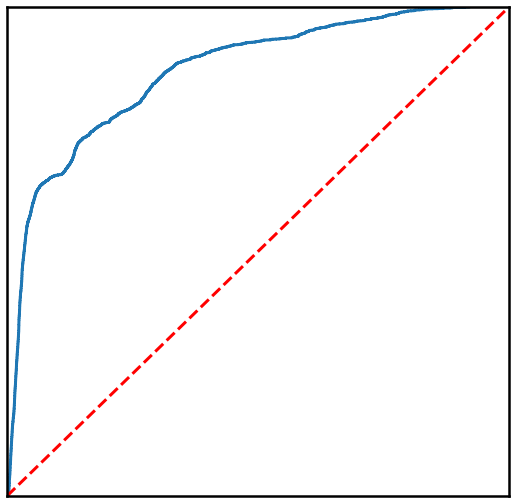

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

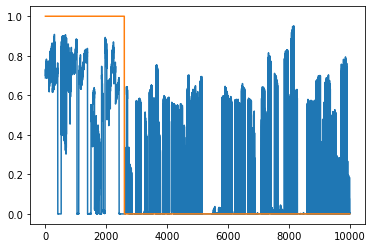

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

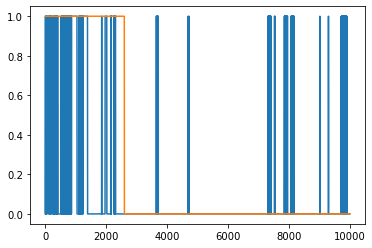

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])